# Contrail Detection Thesis:OBJ-1 Result & Analysis, Part-2

In [2]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

!nvidia-smi

Cleared PyTorch GPU cache.
Tue Jul  9 11:29:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:04:00.0 Off |                  Off |
| 41%   42C    P8     8W / 140W |   4046MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

## Data collection & Preparation

In [5]:
# Training dataframe 
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_VALID_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

Image_ID  Class
821   1074165712766223877      0
244    127580362208497184      1
1224  1597708808159006972      0
1637  1582674860208357528      0
1080  1349536550702205092      1

In [6]:
## MODEL LOADING CONFIG
BANDS_CONFIG = ["ALL", "AshRGB", "Gaussian_ALL", "TDi_Gauss_Contrail_Bands", "AshRGB_RFCH"]
MODEL_DIR = "../contrails_detection/models/checkpoints/Obj1/"

In [5]:
## Pytorch dataset collection 
%time
torch.cuda.empty_cache()
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: gaussian_filter_normalization(x)),
    #transforms.Lambda(lambda x: utils.contrail_detection_preprocessing(x))
])


train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'validation', 
                                 transform=transform, 
                                 sequence_index=config.TS # nth:5 sequence image
                                ) 

valid_dataset = ContrailsDataset(dataframe=valid_df, 
                                 root_dir=config.DATA_DIR+'validation',
                                 transform=transform, 
                                 sequence_index=config.TS
                                )
## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=config.WORKERS, 
                              pin_memory=True, 
                              prefetch_factor=config.WORKERS,
                             )

valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=config.BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=config.WORKERS, 
                              prefetch_factor=config.WORKERS
                             )

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 12.9 µs


In [6]:
%%time
tr_image, tr_mask = next(iter(train_dataloader))
tr_image.shape, tr_mask.shape

CPU times: user 1.65 s, sys: 967 ms, total: 2.62 s
Wall time: 12.6 s


(torch.Size([4, 9, 256, 256]), torch.Size([4, 1, 256, 256]))

### Data exploration & visualization

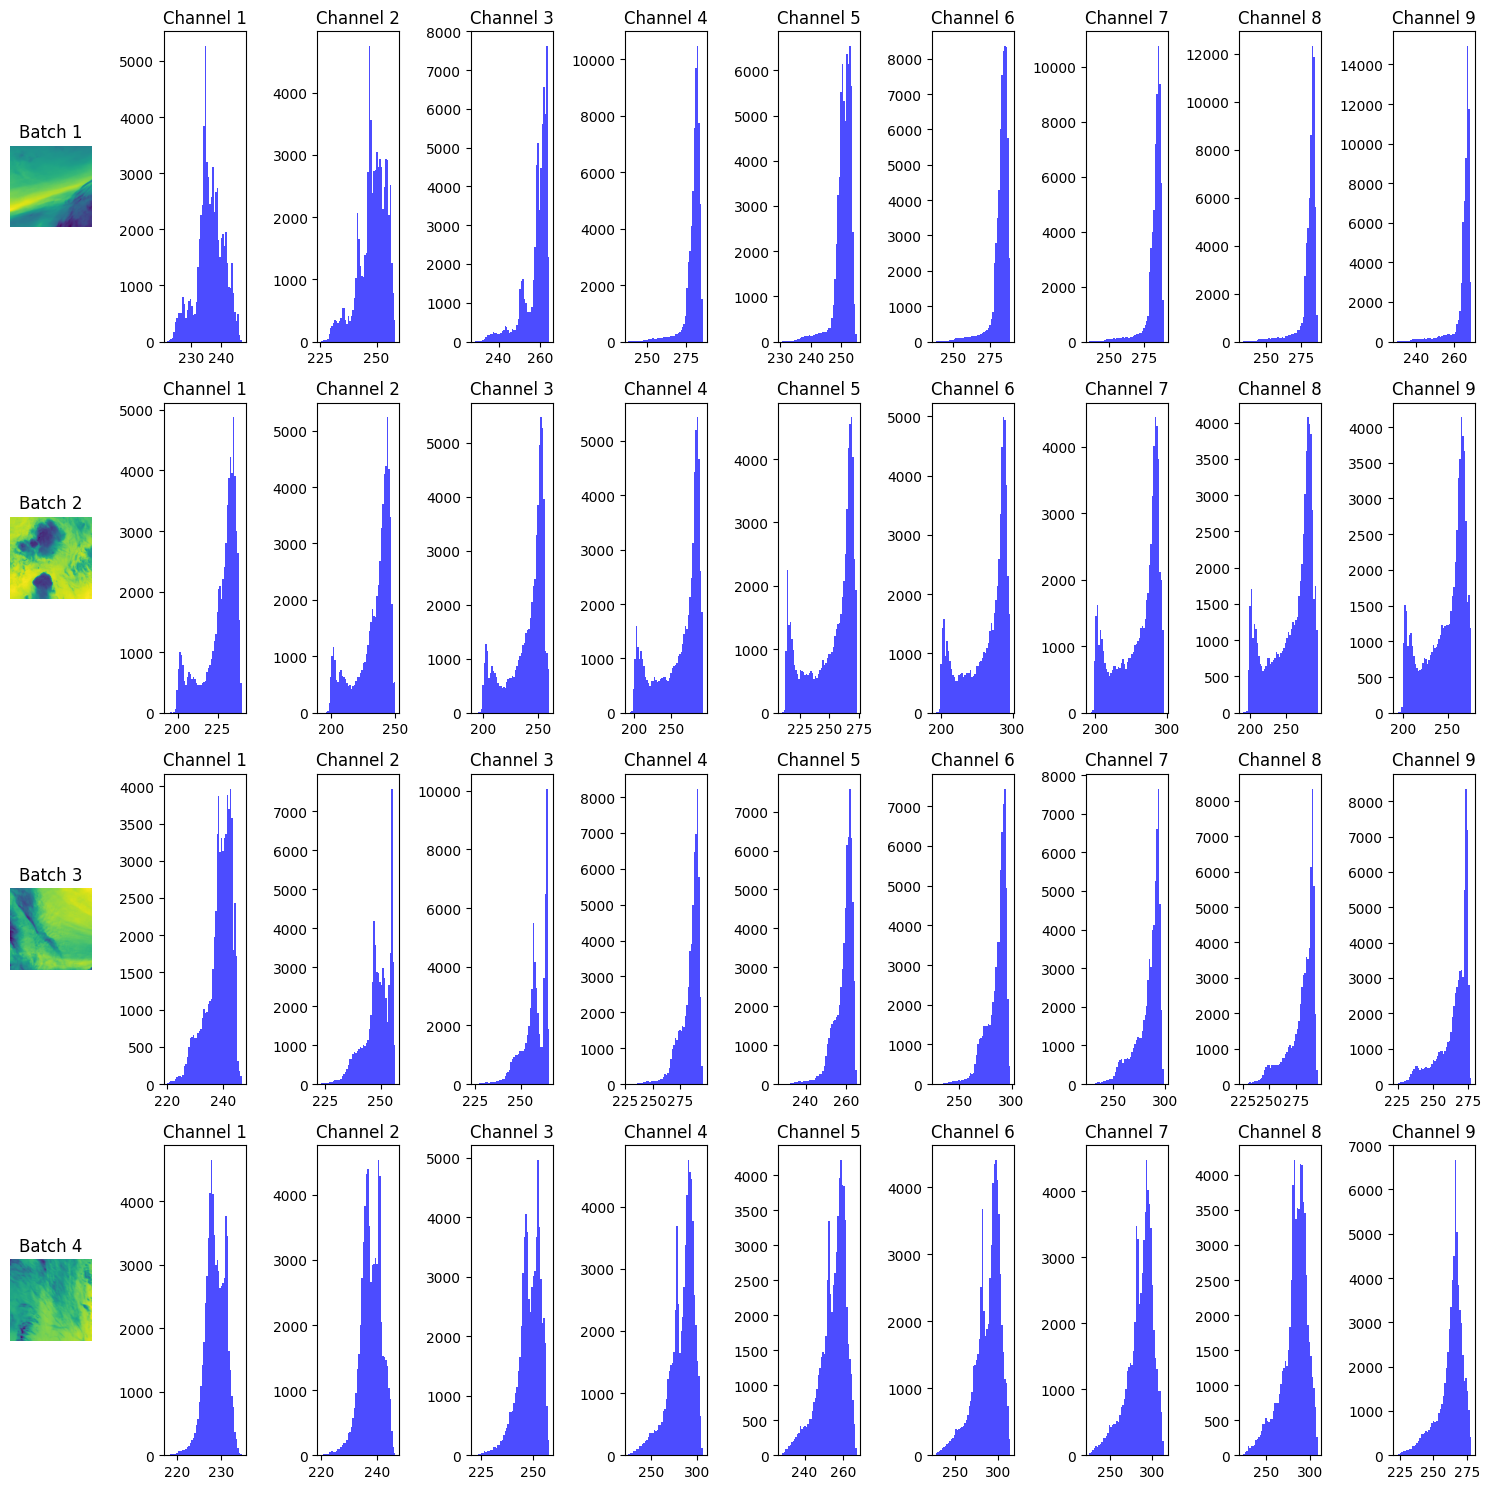

In [7]:
# Bands histogram


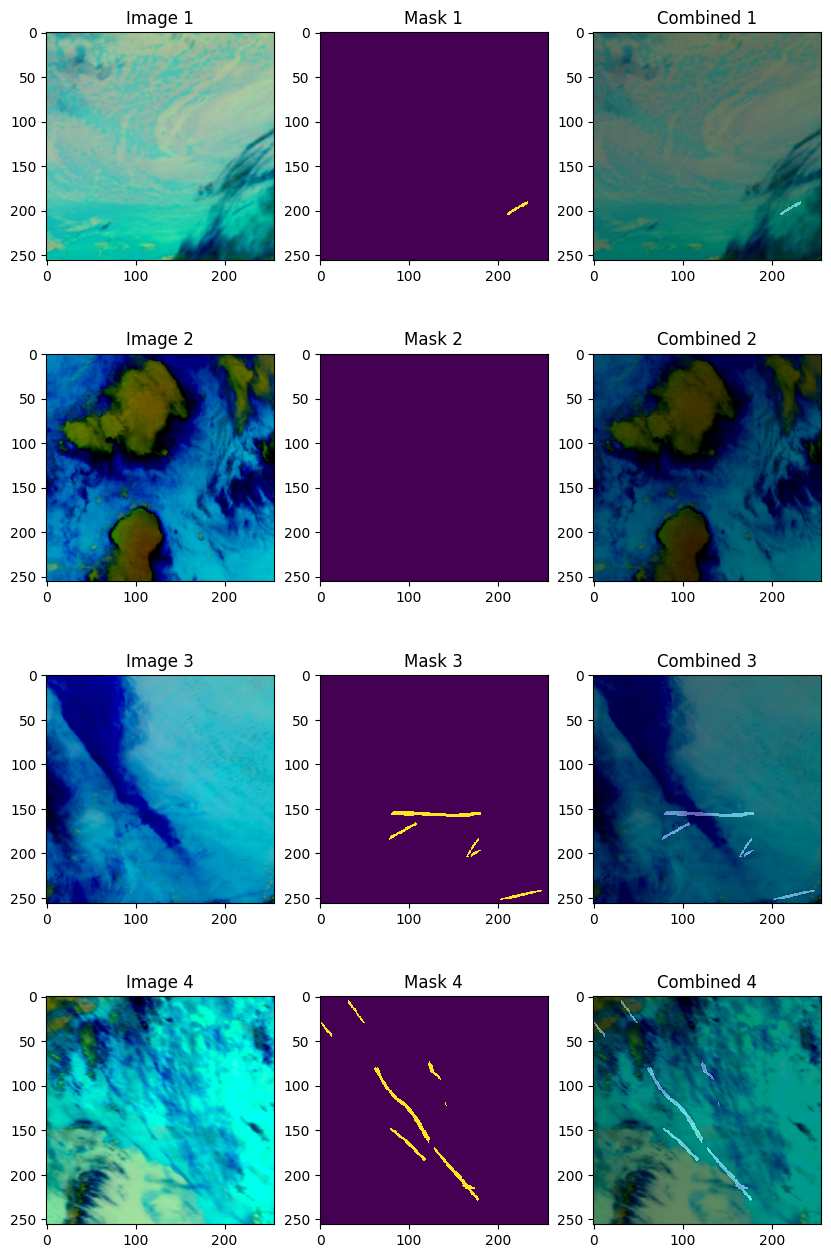

In [8]:
# RGB & mask 
utils.plot_rgb_and_mask(tr_image/256, tr_mask)

### Model Loading & Prediction

In [11]:
# Load saved model from directory
IN_CH = 9
EXP_NAME = config.NAME + BANDS_CONFIG[0]
model_chkp = MODEL_DIR + EXP_NAME
MODEL_PKL = "/last.ckpt"
model_checkpoint_path = model_chkp + MODEL_PKL
checkpoint = torch.load(model_checkpoint_path)

# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}
# Load model 
model_v = BaseUnet(in_channels=IN_CH, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = tr_image.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

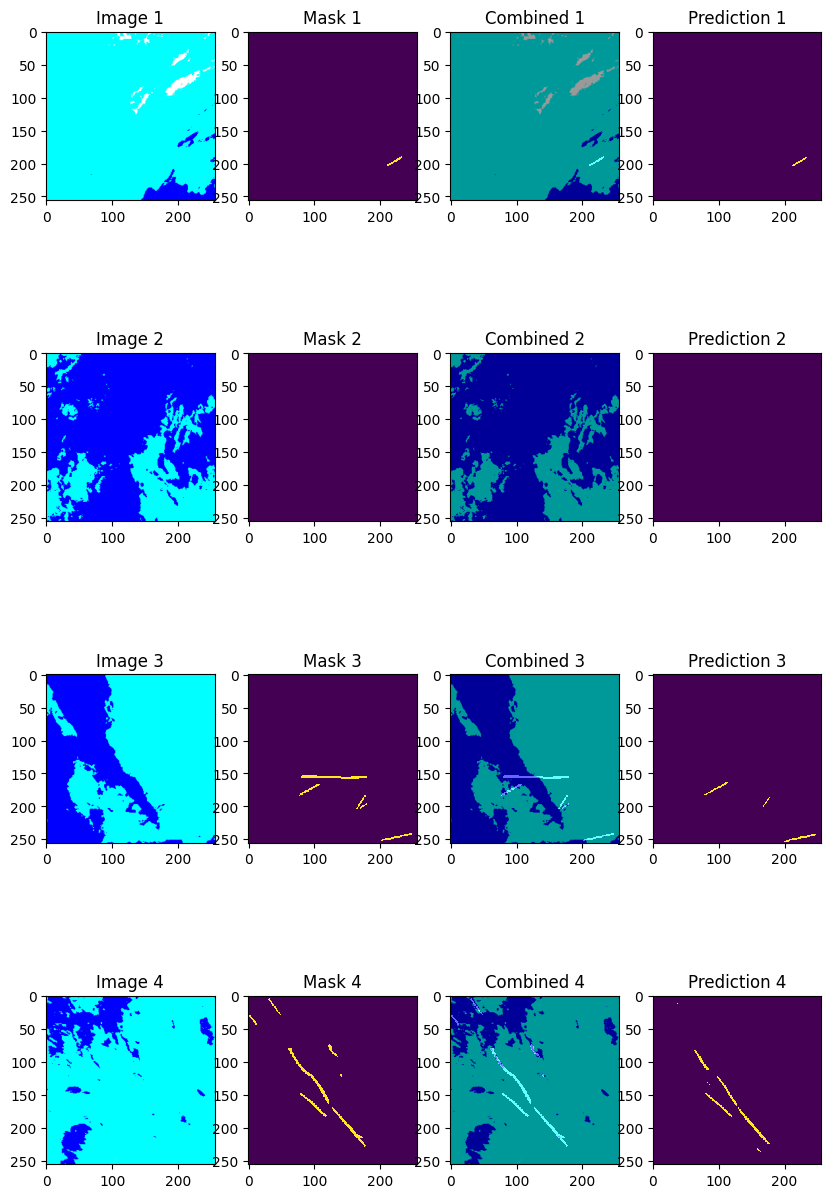

In [13]:
utils.plot_rgb_and_mask(tr_image, tr_mask, prediction.detach() > 0.5)

### Accuracy Assessment

In [14]:
len(train_dataloader)

371

In [15]:
%%time
# Initialize lists for storing predictions and labels
all_preds = []
all_labels = []

# Inference and accuracy assessment
with torch.no_grad():
    for data, labels in iter(train_dataloader):
        data = data.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        outputs = torch.sigmoid(model_v(data)).cpu().detach().numpy()
        # Flatten the batch dimension and append to lists
        all_preds.extend(outputs)
        all_labels.extend(labels.cpu().detach().numpy())
        
# Convert lists to numpy arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_labels.shape

CPU times: user 7.56 s, sys: 3.19 s, total: 10.8 s
Wall time: 13.5 s


(1482, 1, 256, 256)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix
# Function to calculate metrics
def calculate_acc_metrics(preds, labels):
    flat_preds = preds.flatten()
    flat_labels = labels.flatten()

    accuracy = accuracy_score(flat_labels, flat_preds)
    precision = precision_score(flat_labels, flat_preds, zero_division=1)
    recall = recall_score(flat_labels, flat_preds, zero_division=1)
    f1 = f1_score(flat_labels, flat_preds, zero_division=1)
    iou = jaccard_score(flat_labels, flat_preds)

    return accuracy, precision, recall, f1, iou

In [22]:
%%time
# Binarize predictions
threshold = 0.5
all_preds_bin = (all_preds > threshold).astype(np.uint8)
# Prepare DataFrame for detailed results
results_df = pd.DataFrame(columns=['Image_ID', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'IoU'])

CPU times: user 78.4 ms, sys: 73 ms, total: 151 ms
Wall time: 148 ms


In [23]:
%%time
# Efficiently calculate and store metrics
results_list = []  # Initialize a list to collect results

# Iterate over predictions and labels without using tqdm
for idx, (pred, label) in enumerate(zip(all_preds_bin, all_labels)):
    acc, prec, rec, f1, iou = calculate_acc_metrics(pred, label)
    results_list.append({
        'Image_ID': idx,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'IoU': iou
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results_list)

CPU times: user 2min 6s, sys: 134 ms, total: 2min 6s
Wall time: 2min 6s


In [24]:
results_df.head()

Image_ID  Accuracy  Precision    Recall  F1_Score       IoU
0         0  0.979507   0.850452  0.471311  0.606505  0.435240
1         1  0.999313   0.768116  0.646341  0.701987  0.540816
2         2  1.000000   1.000000  1.000000  1.000000  0.000000
3         3  1.000000   1.000000  1.000000  1.000000  0.000000
4         4  0.995071   0.758226  0.774854  0.766450  0.621336

In [25]:
results_df.describe().T

count        mean         std       min         25%    50%  \
Image_ID   1482.0  740.500000  427.960863  0.000000  370.250000  740.5   
Accuracy   1482.0    0.996919    0.007037  0.919556    0.996979    1.0   
Precision  1482.0    0.859971    0.250729  0.000000    0.802639    1.0   
Recall     1482.0    0.774392    0.301771  0.000000    0.568664    1.0   
F1_Score   1482.0    0.758884    0.313817  0.000000    0.611075    1.0   
IoU        1482.0    0.183500    0.245794  0.000000    0.000000    0.0   

                   75%          max  
Image_ID   1110.750000  1481.000000  
Accuracy      1.000000     1.000000  
Precision     1.000000     1.000000  
Recall        1.000000     1.000000  
F1_Score      1.000000     1.000000  
IoU           0.422765     0.867797

In [26]:
res_paths = 'result_outs/'+EXP_NAME+'.csv'
results_df.to_csv(res_paths)

In [27]:
!ls result_outs

baseline-unetALL.csv


In [41]:
# Get Aggrigated Matrix matrics 
cl_acc0, cl_acc1, fp_rate, fn_rate, conf_x = utils.get_post_acc_matrix(all_preds_bin, all_labels)
# Store metrics
metrics = {
        'Class_Accuracy': [],
        'False_Positive_Rate': [],
        'False_Negative_Rate': [],
        'Confusion_Matrix': []
    }
metrics['Class_Accuracy'].append([cl_acc0, cl_acc1])
metrics['False_Positive_Rate'].append(fp_rate)
metrics['False_Negative_Rate'].append(fn_rate)
metrics['Confusion_Matrix'].append(conf_x)

In [42]:
metrics

{'Class_Accuracy': [[0.9989595141660604, 0.5942367267254389]],
 'False_Positive_Rate': [0.002054080613698671],
 'False_Negative_Rate': [0.2568007621246523],
 'Confusion_Matrix': [[0.0029960560251665823,
   0.00204580000698486,
   0.9939229041136871,
   0.0010352398541613951]]}

In [70]:
results_df.head()

Image_ID  Accuracy  Precision    Recall  F1_Score       IoU
0         0  0.992966   0.797884  0.736328  0.765871  0.620576
1         1  0.984238   0.672883  0.776614  0.721037  0.563767
2         2  0.997910   0.769231  0.376344  0.505415  0.338164
3         3  0.998322   0.972973  0.400000  0.566929  0.395604
4         4  1.000000   1.000000  1.000000  1.000000  0.000000

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc(true_labels, pred_probs):
    """
    Plot ROC-AUC curve.

    Parameters:
        true_labels (numpy.array): Ground truth binary labels (flattened).
        pred_probs (numpy.array): Predicted probabilities for the positive class (flattened).
    """
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc = roc_auc_score(true_labels, pred_probs)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [44]:
all_preds.shape

(1482, 1, 256, 256)

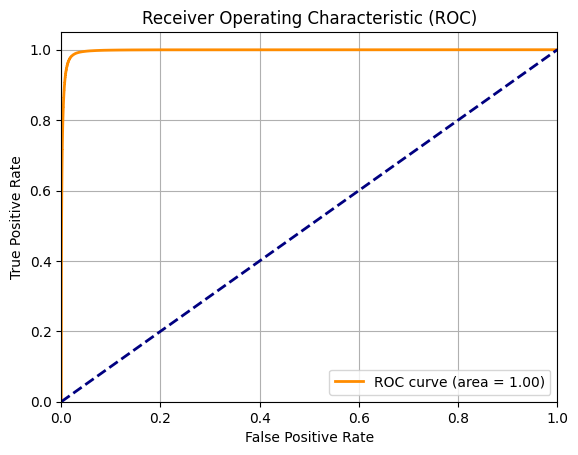

In [46]:
%%time
plot_roc_auc(all_labels.flatten(), all_preds.flatten())

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_results_with_overlay(preds, labels, n_samples=5, alpha=0.5):
    """
    Visualize actual and predicted masks on the same image with different colors.

    Parameters:
        preds (list or ndarray): List or array of predicted masks.
        labels (list or ndarray): List or array of ground truth masks.
        n_samples (int): Number of samples to visualize.
        alpha (float): Transparency level for overlaying the masks.
    """
    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples * 5, 10))
    if n_samples == 1:
        axes = [axes]  # Ensure axes is iterable for a single sample case

    # Set a single title for the whole figure
    fig.suptitle('Overlay of Predicted and Ground Truth Masks:Red - Predicted, Green - Ground Truth', fontsize=16)

    for i in range(n_samples):
        pred_mask = preds[i][0]  # Assuming mask has a single channel
        true_mask = labels[i][0]

        # Create color masks
        pred_colored = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.float32)
        true_colored = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.float32)

        # Color the predicted mask in red (R=1)
        pred_colored[:, :, 0] = pred_mask

        # Color the true mask in green (G=1)
        true_colored[:, :, 1] = true_mask

        # Combine the masks with different colors
        overlay = np.clip(alpha * pred_colored + alpha * true_colored, 0, 1)

        # Display the result
        axes[i].imshow(overlay)
        axes[i].set_title(f'Sample {i + 1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `all_preds_bin` and `all_labels` are lists of predicted and ground truth masks
# visualize_results_with_overlay(all_preds_bin, all_labels, n_samples=5, alpha=0.5)

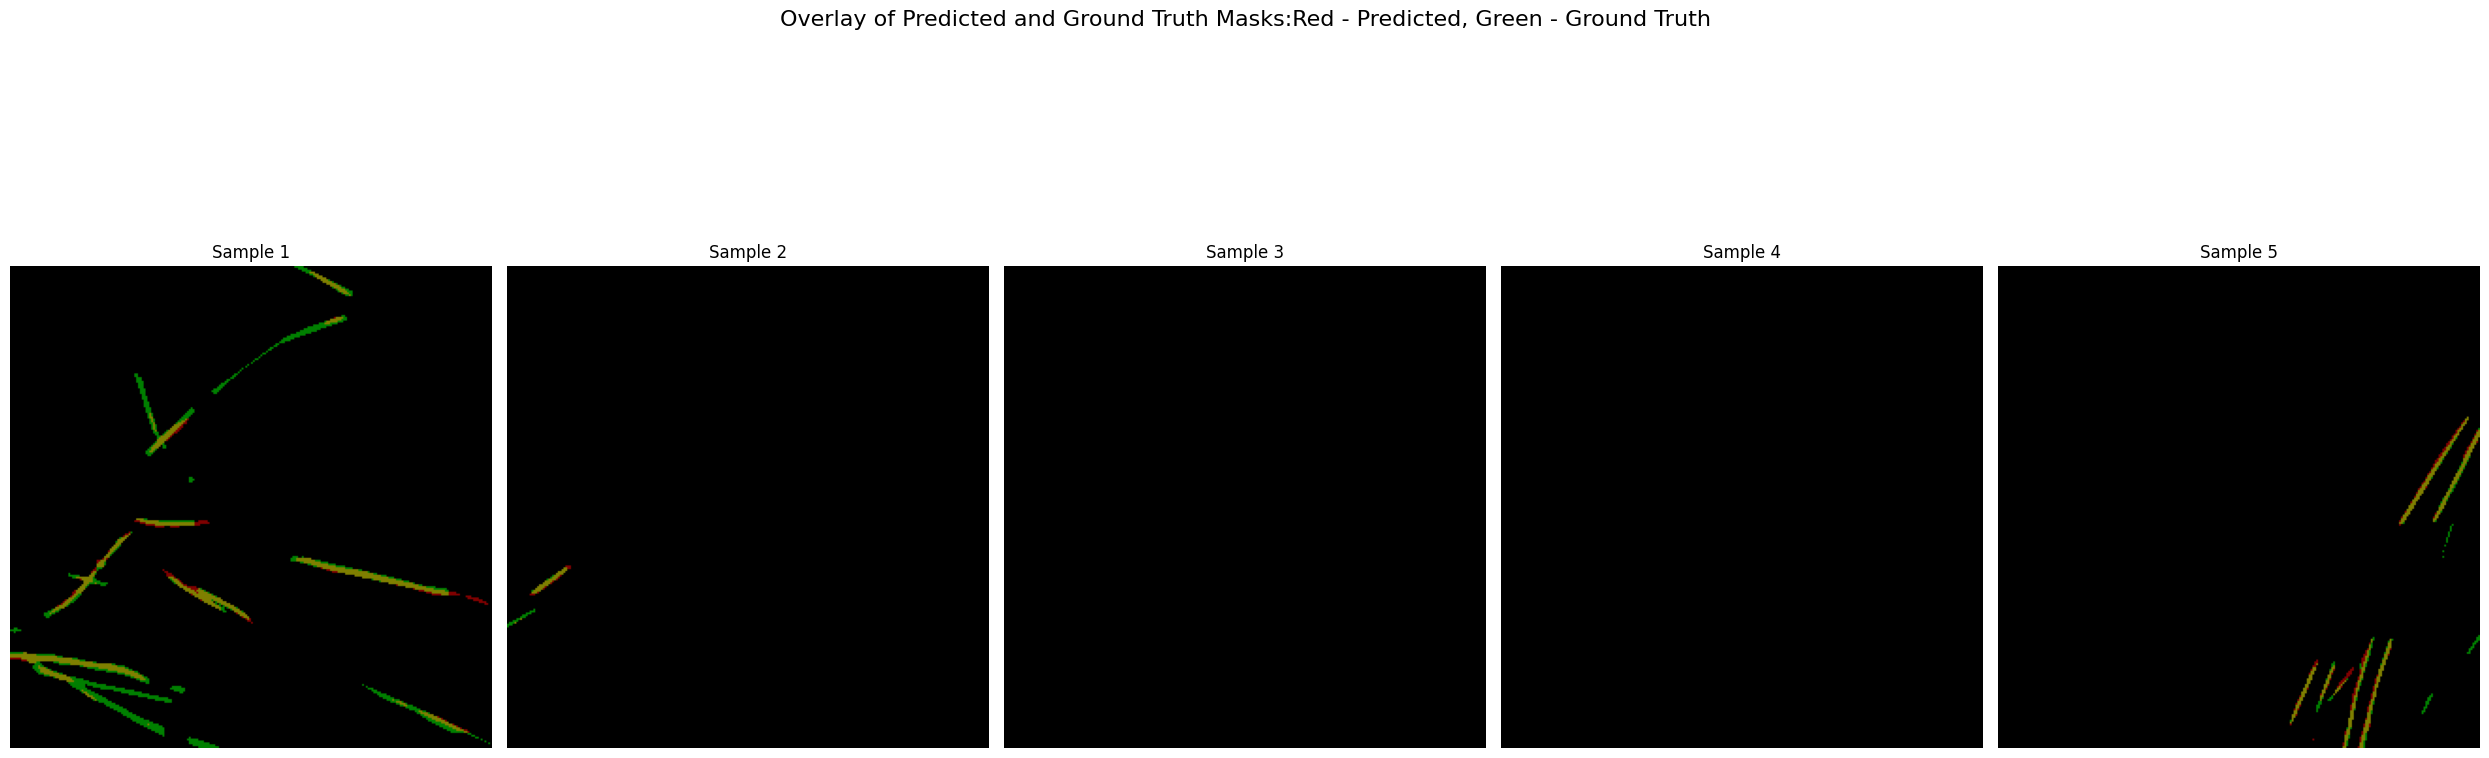

In [58]:
# Example usage
# Assuming `vl_image`, `all_preds_bin`, and `all_labels` are lists of NumPy arrays
visualize_results_with_overlay(all_preds_bin, all_labels)

## Model-4 Results & Analysis: UNET-GaussianALL

#### Data loading

In [7]:
%time
torch.cuda.empty_cache()
torch.manual_seed(11)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: utils.gaussian_filter_normalization(x)),
    #transforms.Lambda(lambda x: utils.contrail_detection_preprocessing(x))
])


train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'validation', 
                                 transform=transform, 
                                 sequence_index=config.TS # nth:5 sequence image
                                ) 
## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=config.WORKERS, 
                              pin_memory=True, 
                              prefetch_factor=config.WORKERS,
                             )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [5]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([4, 9, 256, 256]), torch.Size([4, 1, 256, 256]))

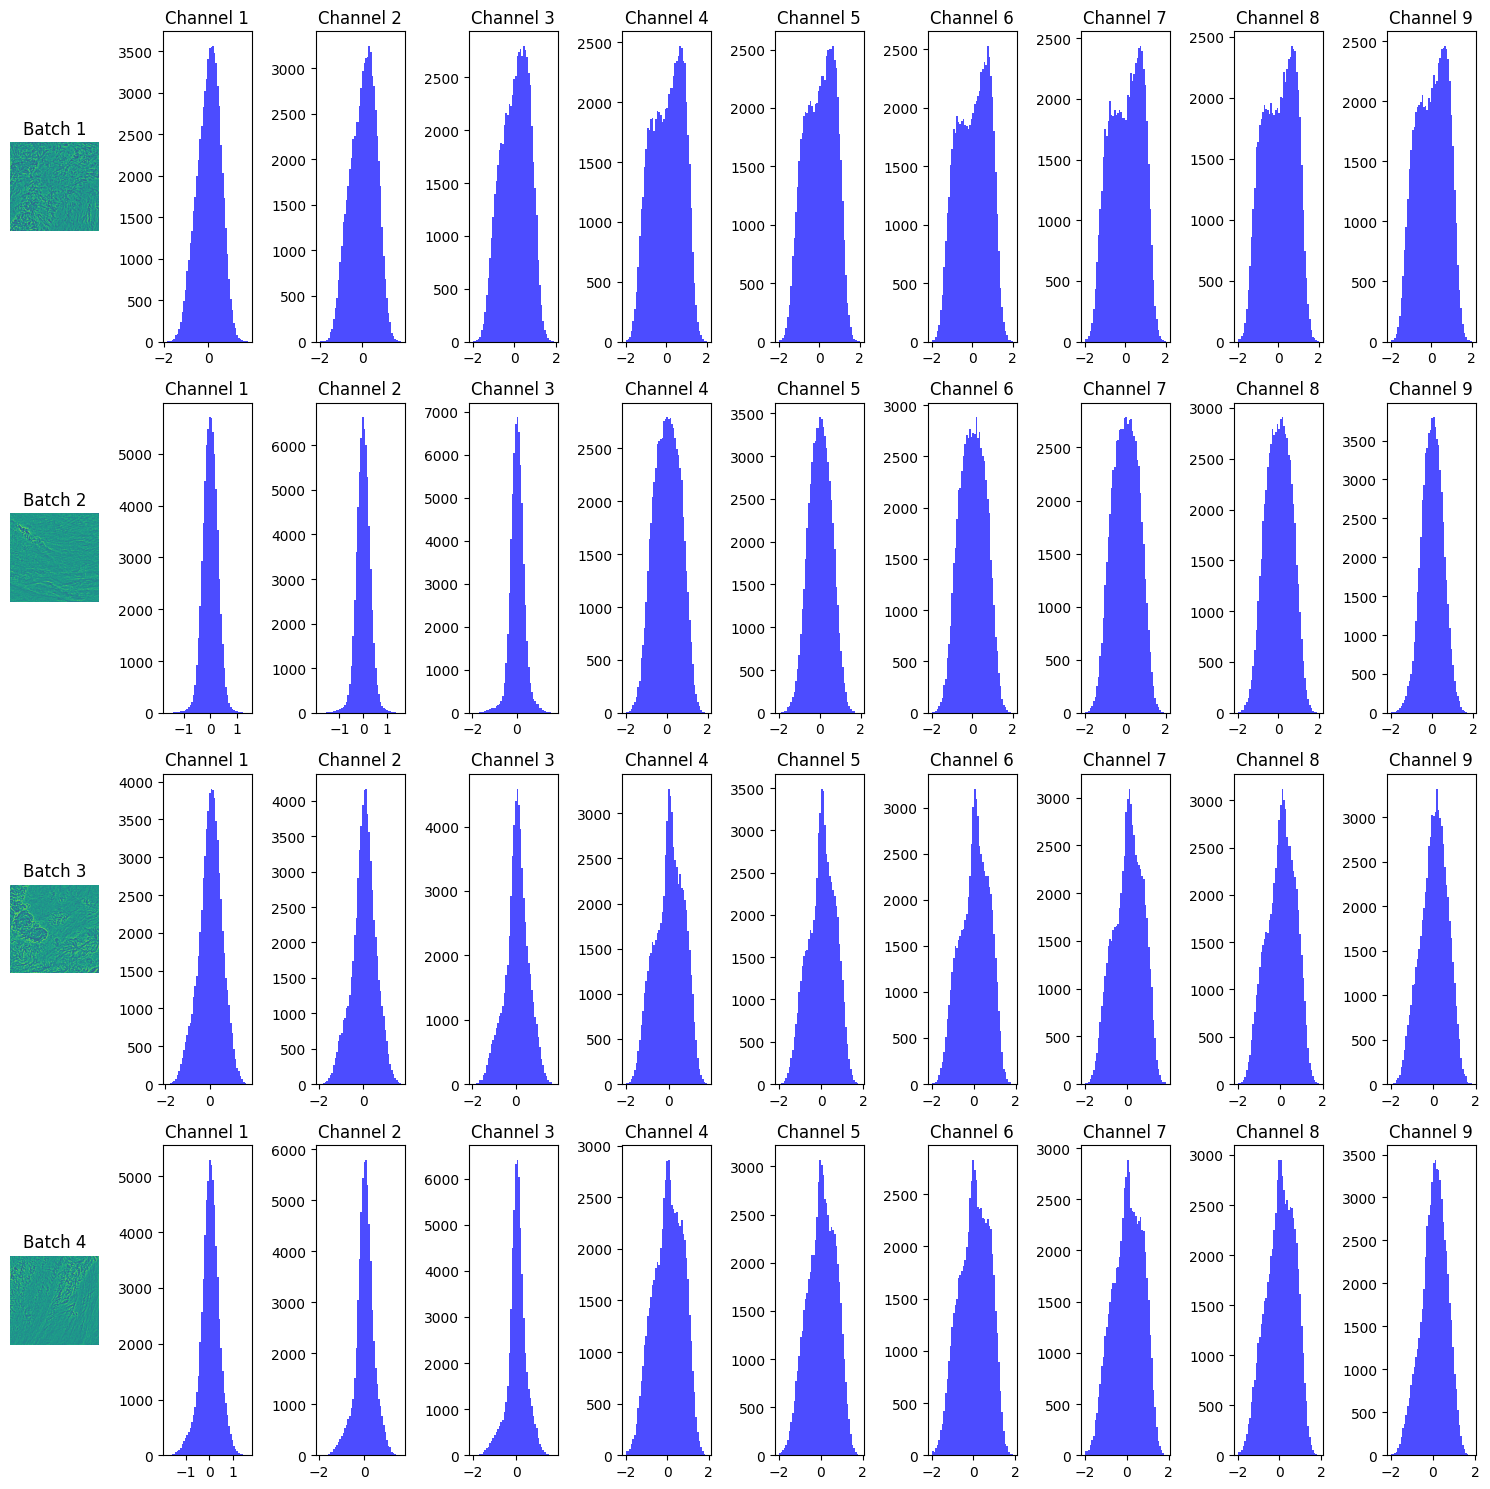

In [6]:
utils.plot_batch_histogram(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


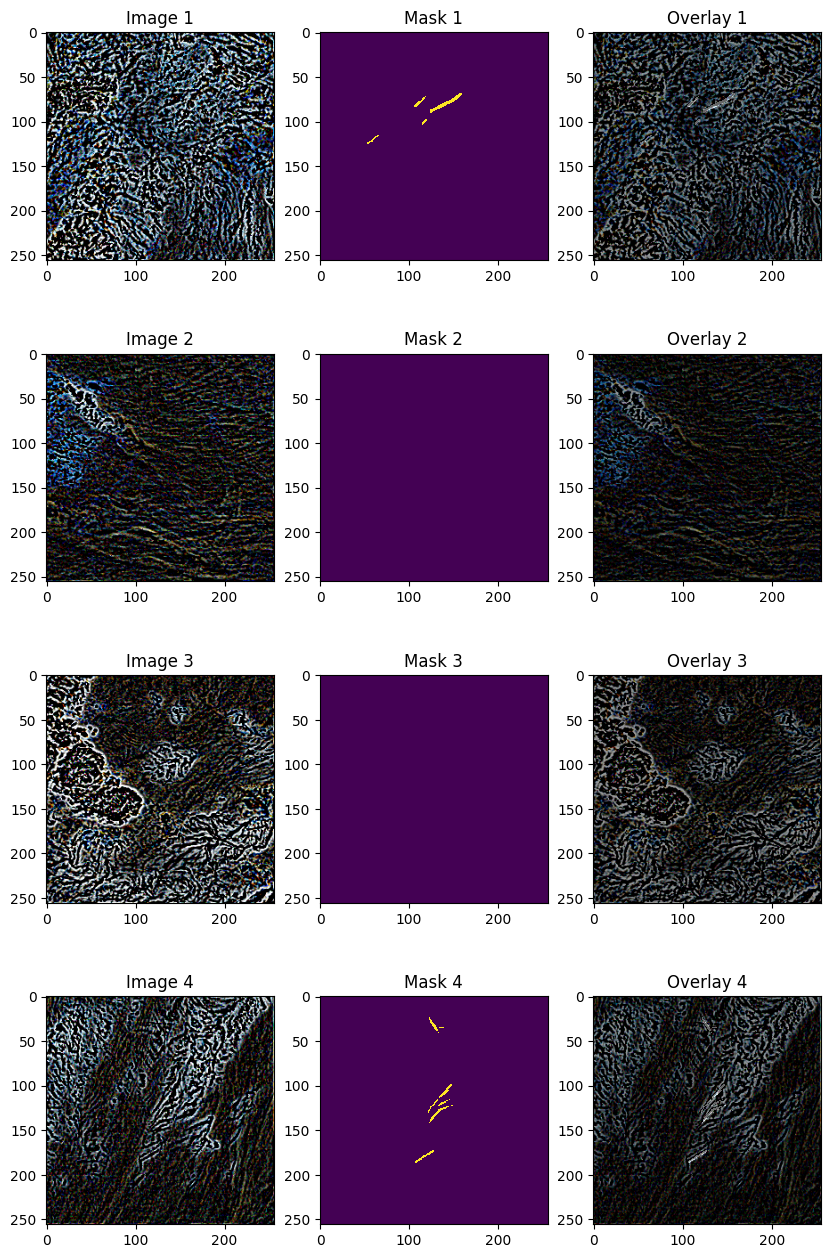

In [7]:
utils.plot_image_and_mask(image, mask)

#### Model Loading & Prediction

In [8]:
BANDS_CONFIG[]

['ALL', 'AshRGB', 'Gaussian_ALL', 'TDi_Gauss_Contrail_Bands', 'AshRGB_RFCH']

In [10]:
# Load saved model from directory
IN_CH = 9
EXP_NAME = config.NAME + BANDS_CONFIG[2]
model_chkp = MODEL_DIR + EXP_NAME
MODEL_PKL = "/last.ckpt"
model_checkpoint_path = model_chkp + MODEL_PKL
checkpoint = torch.load(model_checkpoint_path)

# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}
# Load model 
model_v = BaseUnet(in_channels=IN_CH, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


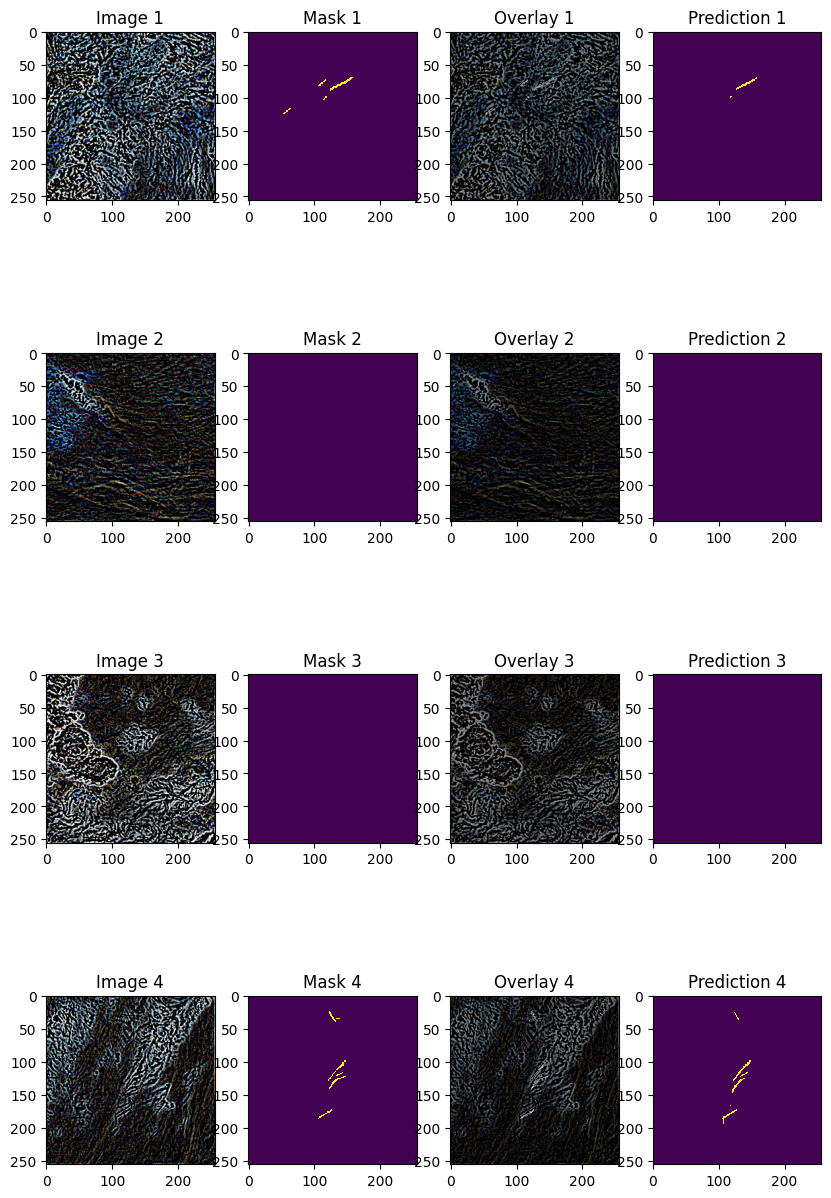

In [12]:
utils.plot_image_and_mask(image, mask, prediction.detach()>0.5)

### Accuracy Assessment

In [13]:
%%time
# Initialize lists for storing predictions and labels
all_preds = []
all_labels = []

# Inference and accuracy assessment
with torch.no_grad():
    for data, labels in iter(train_dataloader):
        data = data.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        outputs = torch.sigmoid(model_v(data)).cpu().detach().numpy()
        # Flatten the batch dimension and append to lists
        all_preds.extend(outputs)
        all_labels.extend(labels.cpu().detach().numpy())
        
# Convert lists to numpy arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_labels.shape

CPU times: user 8.15 s, sys: 3.28 s, total: 11.4 s
Wall time: 31.1 s


(1482, 1, 256, 256)

In [14]:
%%time
# Binarize predictions
threshold = 0.5
all_preds_bin = (all_preds > threshold).astype(np.uint8)
# Prepare DataFrame for detailed results
gauss_all_results_df = pd.DataFrame(columns=['Image_ID', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'IoU'])

CPU times: user 109 ms, sys: 66.8 ms, total: 175 ms
Wall time: 172 ms


In [15]:
%%time
# Efficiently calculate and store metrics
results_list = []  # Initialize a list to collect results

# Iterate over predictions and labels without using tqdm
for idx, (pred, label) in enumerate(zip(all_preds_bin, all_labels)):
    acc, prec, rec, f1, iou = utils.calculate_acc_metrics(pred, label)
    results_list.append({
        'Image_ID': idx,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'IoU': iou
    })

# Convert the list of results to a DataFrame
gauss_all_results_df = pd.DataFrame(results_list)

CPU times: user 1min 57s, sys: 86.6 ms, total: 1min 57s
Wall time: 1min 57s


In [16]:
gauss_all_results_df.describe()

Image_ID     Accuracy    Precision       Recall     F1_Score  \
count  1482.000000  1482.000000  1482.000000  1482.000000  1482.000000   
mean    740.500000     0.997185     0.879180     0.801582     0.798508   
std     427.960863     0.006488     0.213707     0.272609     0.278489   
min       0.000000     0.927002     0.000000     0.000000     0.000000   
25%     370.250000     0.997395     0.811233     0.640539     0.672912   
50%     740.500000     1.000000     1.000000     1.000000     1.000000   
75%    1110.750000     1.000000     1.000000     1.000000     1.000000   
max    1481.000000     1.000000     1.000000     1.000000     1.000000   

               IoU  
count  1482.000000  
mean      0.206818  
std       0.266593  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.482457  
max       0.872414

In [17]:
res_paths = 'result_outs/'+EXP_NAME+'.csv'
gauss_all_results_df.to_csv(res_paths)

In [19]:
# Get Aggrigated Matrix matrics 
cl_acc0, cl_acc1, fp_rate, fn_rate, conf_x = utils.get_post_acc_matrix(all_preds_bin, all_labels)
# Store metrics
gauss_all_metrics = {
        'Class_Accuracy': [],
        'False_Positive_Rate': [],
        'False_Negative_Rate': [],
        'Confusion_Matrix': []
    }
gauss_all_metrics['Class_Accuracy'].append([cl_acc0, cl_acc1])
gauss_all_metrics['False_Positive_Rate'].append(fp_rate)
gauss_all_metrics['False_Negative_Rate'].append(fn_rate)
gauss_all_metrics['Confusion_Matrix'].append(conf_x)

In [20]:
gauss_all_metrics

{'Class_Accuracy': [[0.9989463304912373, 0.6496067896431802]],
 'False_Positive_Rate': [0.0017743034659623183],
 'False_Negative_Rate': [0.24247425135440853],
 'Confusion_Matrix': [[0.9939097869090545,
   0.0010483570587940705,
   0.0032752239108890012,
   0.001766632121262441]]}

In [21]:
# Path to save the JSON file
import json
json_file_path = "result_outs/gauss_all_metrics.json"

# Save the dictionary to a JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(gauss_all_metrics, json_file, indent=4)

print(f"Metrics saved to {json_file_path}")

Metrics saved to result_outs/gauss_all_metrics.json


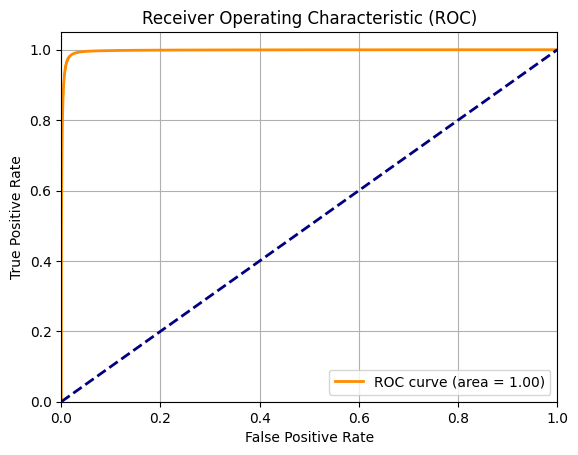

In [22]:
utils.plot_roc_auc(all_labels.flatten(), all_preds.flatten())

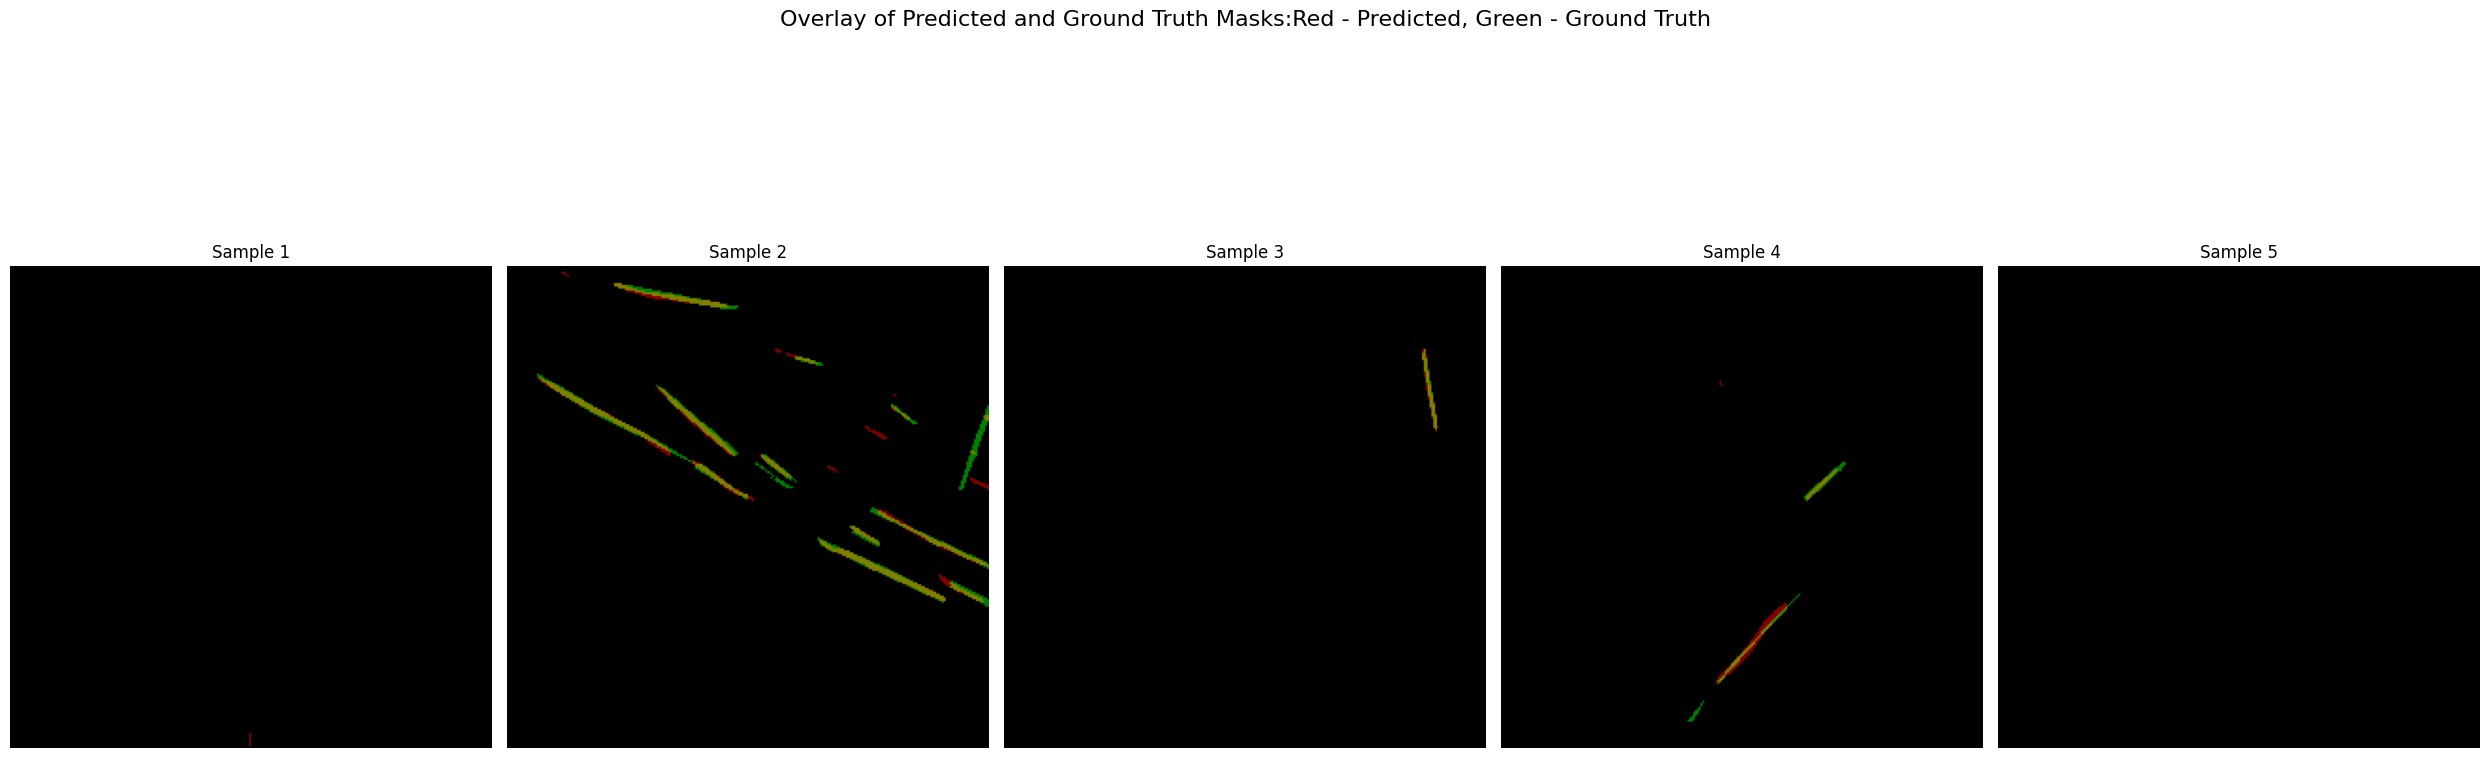

In [23]:
utils.visualize_results_with_overlay(all_preds_bin, all_labels)

## Model-5 Result & Analysis: UNet-GaussianTDi_Bands

#### Data loading

In [8]:
%time
torch.cuda.empty_cache()
torch.manual_seed(77)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: utils.contrail_detection_preprocessing(x))
])


train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'validation', 
                                 transform=transform, 
                                 sequence_index=config.TS # nth:5 sequence image
                                ) 
## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=config.WORKERS, 
                              pin_memory=True, 
                              prefetch_factor=config.WORKERS,
                             )

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs


In [9]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([4, 6, 256, 256]), torch.Size([4, 1, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


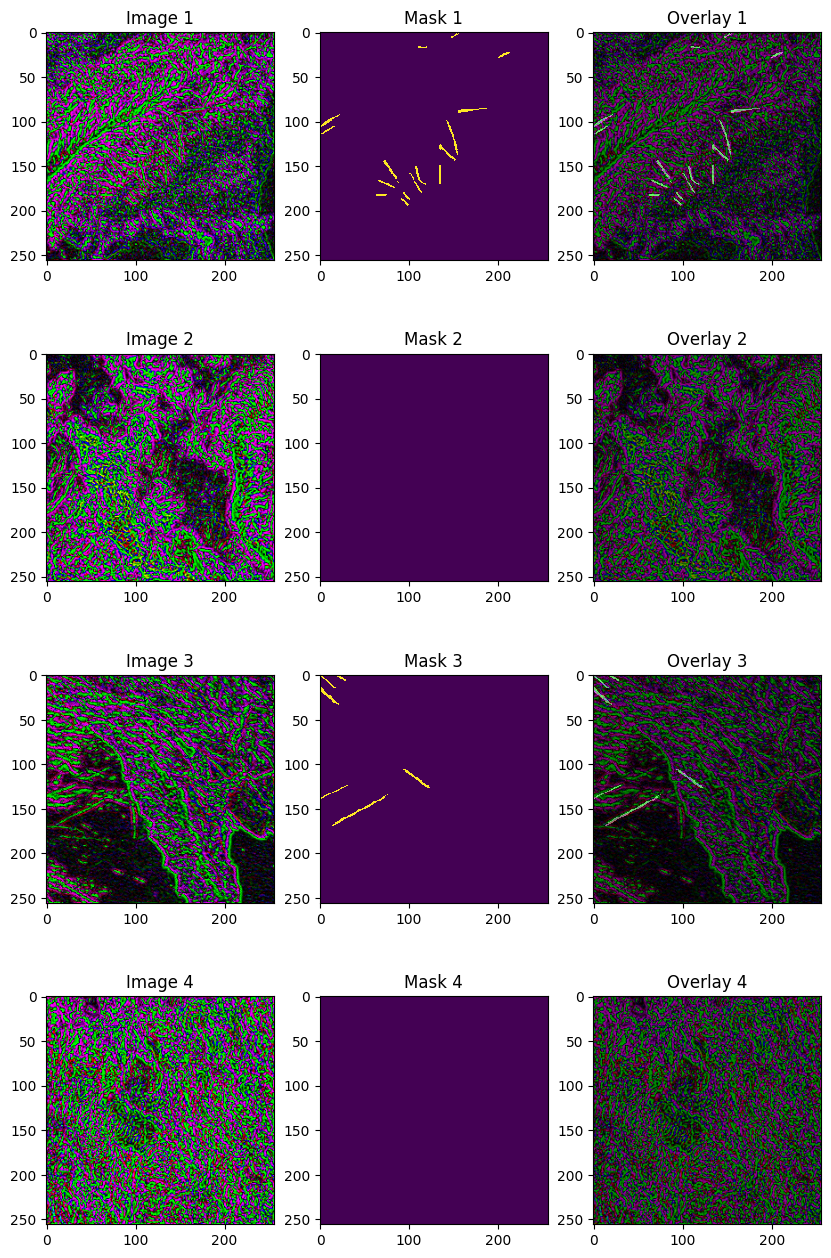

In [10]:
utils.plot_image_and_mask(image, mask)

#### Model Loading

In [11]:
BANDS_CONFIG[-2]

'TDi_Gauss_Contrail_Bands'

In [12]:
# Load saved model from directory
IN_CH = 6
EXP_NAME = config.NAME + BANDS_CONFIG[-2]
model_chkp = MODEL_DIR + EXP_NAME
MODEL_PKL = "/last.ckpt"
model_checkpoint_path = model_chkp + MODEL_PKL
checkpoint = torch.load(model_checkpoint_path)

# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}
# Load model 
model_v = BaseUnet(in_channels=IN_CH, out_channels=1)
model_v.load_state_dict(filtered_state_dict)
model_v.eval()

model = model_v.to(config.DEVICE)
data = image.to(config.DEVICE)
prediction = torch.sigmoid(model_v(data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


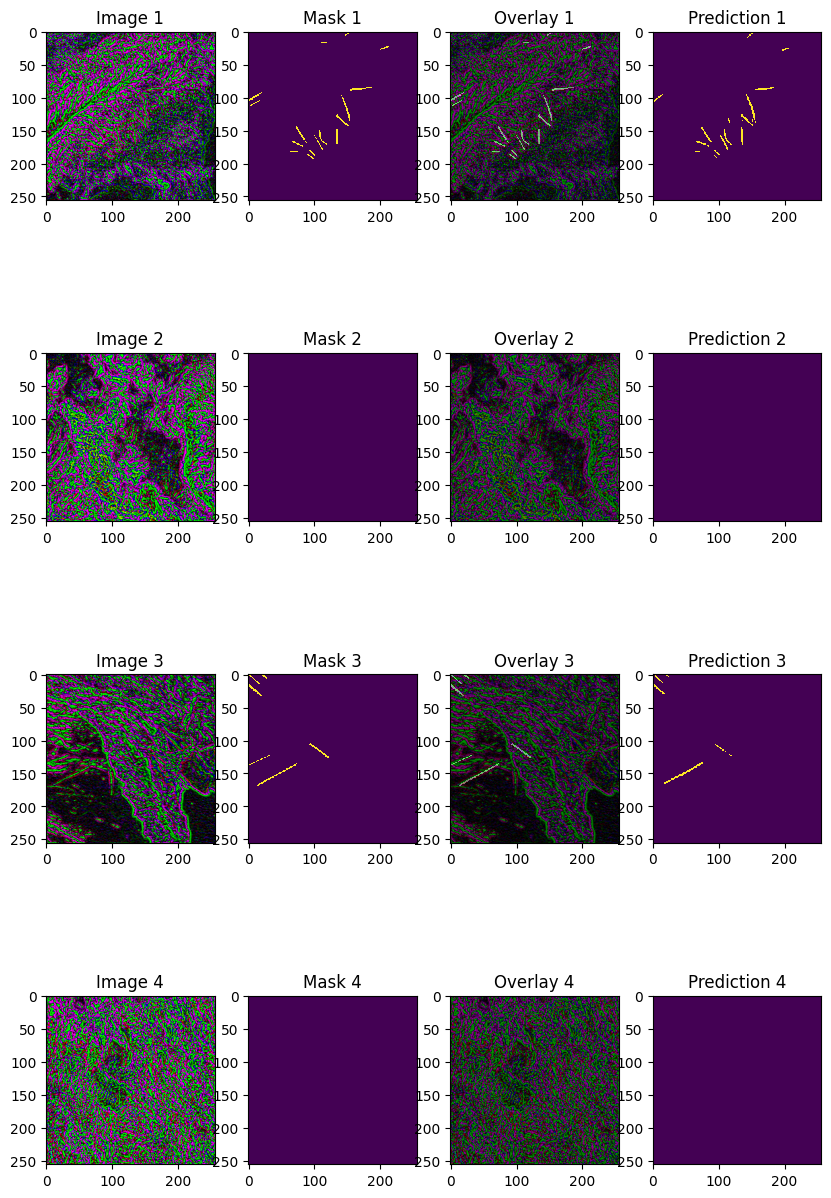

In [13]:
utils.plot_image_and_mask(image, mask, prediction.detach()>0.5)

#### Accuracy Assessment

In [14]:
%%time
# Initialize lists for storing predictions and labels
all_preds = []
all_labels = []

# Inference and accuracy assessment
with torch.no_grad():
    for data, labels in iter(train_dataloader):
        data = data.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        outputs = torch.sigmoid(model_v(data)).cpu().detach().numpy()
        # Flatten the batch dimension and append to lists
        all_preds.extend(outputs)
        all_labels.extend(labels.cpu().detach().numpy())
        
# Convert lists to numpy arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_labels.shape

CPU times: user 7.96 s, sys: 3.15 s, total: 11.1 s
Wall time: 6min 24s


(1482, 1, 256, 256)

In [15]:
%%time
# Binarize predictions
threshold = 0.5
all_preds_bin = (all_preds > threshold).astype(np.uint8)
# Prepare DataFrame for detailed results
gauss_contbands_results_df = pd.DataFrame(columns=['Image_ID', 'Accuracy',
                                                   'Precision', 'Recall', 'F1_Score', 'IoU'])

CPU times: user 56.4 ms, sys: 8.09 ms, total: 64.5 ms
Wall time: 62.7 ms


In [16]:
%%time
# Efficiently calculate and store metrics
results_list = []  # Initialize a list to collect results

# Iterate over predictions and labels without using tqdm
for idx, (pred, label) in enumerate(zip(all_preds_bin, all_labels)):
    acc, prec, rec, f1, iou = utils.calculate_acc_metrics(pred, label)
    results_list.append({
        'Image_ID': idx,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'IoU': iou
    })

# Convert the list of results to a DataFrame
gauss_contbands_results_df = pd.DataFrame(results_list)

CPU times: user 2min 4s, sys: 64.9 ms, total: 2min 4s
Wall time: 2min 4s


In [17]:
EXP_NAME

'baseline-unetTDi_Gauss_Contrail_Bands'

In [18]:
res_paths = 'result_outs/'+EXP_NAME+'.csv'
gauss_contbands_results_df.to_csv(res_paths)

In [19]:
gauss_contbands_results_df.describe()

Image_ID     Accuracy    Precision       Recall     F1_Score  \
count  1482.000000  1482.000000  1482.000000  1482.000000  1482.000000   
mean    740.500000     0.997252     0.884028     0.807401     0.810046   
std     427.960863     0.006424     0.207230     0.261714     0.263946   
min       0.000000     0.922119     0.000000     0.000000     0.000000   
25%     370.250000     0.997421     0.821154     0.642301     0.691130   
50%     740.500000     1.000000     1.000000     1.000000     1.000000   
75%    1110.750000     1.000000     1.000000     1.000000     1.000000   
max    1481.000000     1.000000     1.000000     1.000000     1.000000   

               IoU  
count  1482.000000  
mean      0.214668  
std       0.271357  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.503323  
max       0.869718

In [20]:
# Get Aggrigated Matrix matrics 
cl_acc0, cl_acc1, fp_rate, fn_rate, conf_x = utils.get_post_acc_matrix(all_preds_bin, all_labels)
# Store metrics
gauss_contb_metrics = {
        'Class_Accuracy': [],
        'False_Positive_Rate': [],
        'False_Negative_Rate': [],
        'Confusion_Matrix': []
    }
gauss_contb_metrics['Class_Accuracy'].append([cl_acc0, cl_acc1])
gauss_contb_metrics['False_Positive_Rate'].append(fp_rate)
gauss_contb_metrics['False_Negative_Rate'].append(fn_rate)
gauss_contb_metrics['Confusion_Matrix'].append(conf_x)

In [21]:
gauss_contb_metrics

{'Class_Accuracy': [[0.9989901449961046, 0.6542076877679007]],
 'False_Positive_Rate': [0.0017509698012979657],
 'False_Negative_Rate': [0.2334930038474054],
 'Confusion_Matrix': [[0.9939533805074962,
   0.0010047634603523533,
   0.0032984209768524377,
   0.0017434350552990047]]}

In [22]:
# Path to save the JSON file
import json
json_file_path = "result_outs/gauss_contb_metrics.json"

# Save the dictionary to a JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(gauss_contb_metrics, json_file, indent=4)

print(f"Metrics saved to {json_file_path}")

Metrics saved to result_outs/gauss_contb_metrics.json


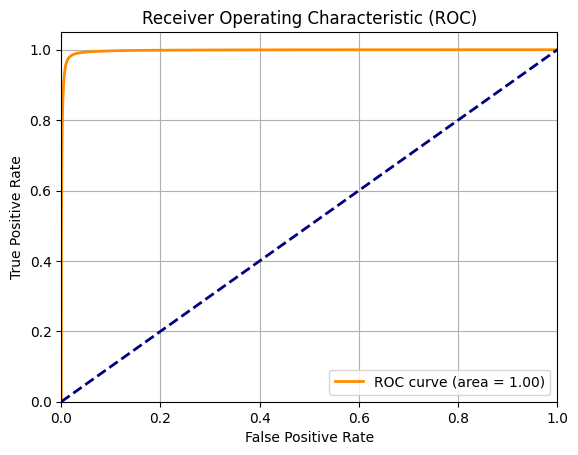

In [23]:
utils.plot_roc_auc(all_labels.flatten(), all_preds.flatten())

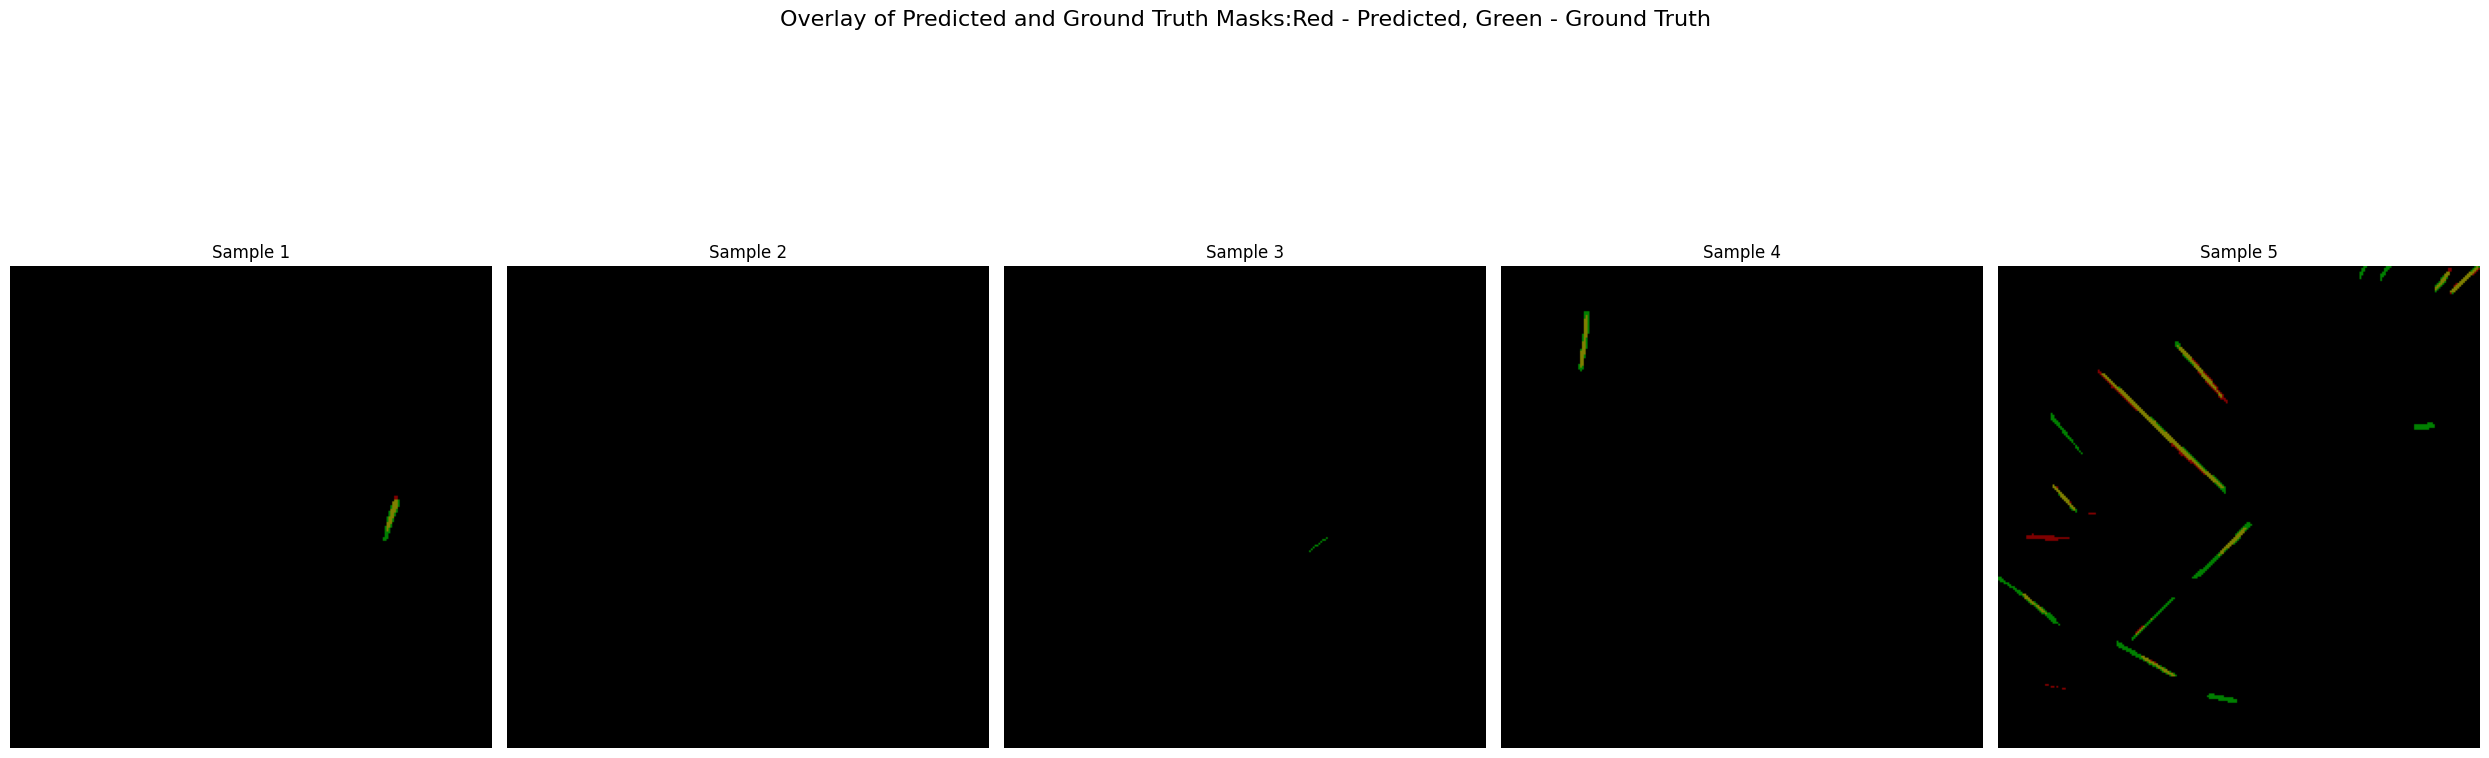

In [24]:
utils.visualize_results_with_overlay(all_preds_bin, all_labels)